In [1]:
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
import nglview as nv

import pandas as pd
from pyntcloud import PyntCloud
# conda install -c conda-forge pyntcloud
# conda install -c conda-forge pythreejs
# https://medium.com/analytics-vidhya/3d-cad-to-binary-voxel-numpy-array-b538d00d97da

/Users/thor/opt/anaconda3/envs/prodna/lib/python3.11/site-packages/pyntcloud/utils/numba.py:4: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/Users/thor/opt/anaconda3/envs/prodna/lib/python3.11/site-packages/pyntcloud/utils/numba.py:11: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/Users/thor/opt/anaconda3/envs/prodna/lib/python3.11/site-packages/pynt

In [2]:
tetra = md.load('./pdbs/tetra.pdb')
traj = tetra.atom_slice(tetra.top.select('chainid 0 1 2 3')).center_coordinates()
view = nv.show_mdtraj(traj)
view

NGLWidget()

Get centers of mass of QGR motifs for DNA 

In [3]:
len(traj.top.to_fasta()[0])

coms = []
QGR_resids = [[111,112,113],[248,249,250],[385,386,387],[522,523,524]]
for ids in QGR_resids:
    com = md.compute_center_of_mass(traj.atom_slice(ids))
    coms.append(com)

coms = np.array(coms)   
coms

array([[[-0.41943889, -2.97641542,  3.19633149]],

       [[-0.60221758, -3.12809075,  2.03043954]],

       [[-2.22030532, -2.35926273,  2.62700717]],

       [[-1.74779287, -2.06924571,  3.62521391]]])

Voxelize the protein strucuture 

In [4]:
# collect atomic coordinates as a numpy array
point_cloud = traj.xyz[0]

# create a dataframe with the atomic coordinates
df = pd.DataFrame(data=point_cloud, columns=['x','y','z'])

# create a PyntCloud object with the dataframe
cloud = PyntCloud(df)

# plot the point cloud  
n = 30 # number of voxels in each dimension of the voxel grid
voxelgrid_id = cloud.add_structure("voxelgrid",n_x=n, n_y=n, n_z=n)
voxelgrid = cloud.structures[voxelgrid_id]
voxelgrid.plot(d=3, mode="density", cmap="hsv")

# get the voxel grid as a numpy array as a binary array
Binary_voxel_array = voxelgrid.get_feature_vector(mode="binary")
Binary_voxel_array.shape 

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(15.549375534057617, 36.1691255569458, 57.686…

(30, 30, 30)

In [5]:
voxels = np.reshape(Binary_voxel_array, (n,n,n))
voxels.shape, coms.shape

((30, 30, 30), (4, 1, 3))

In [6]:
def convert_to_voxels(point_cloud, n=30):

    # create a dataframe with the atomic coordinates
    df = pd.DataFrame(data=point_cloud, columns=['x','y','z'])

    # create a PyntCloud object with the dataframe
    cloud = PyntCloud(df)

    # plot the point cloud  
    n = n # number of voxels in each dimension of the voxel grid
    voxelgrid_id = cloud.add_structure("voxelgrid",n_x=n, n_y=n, n_z=n)
    voxelgrid = cloud.structures[voxelgrid_id]

    # get the voxel grid as a numpy array as a binary array
    Binary_voxel_array = voxelgrid.get_feature_vector(mode="binary")
    return voxelgrid, Binary_voxel_array


# load pdb with mdtraj
tetra = md.load('./pdbs/tetra.pdb')
traj = tetra.atom_slice(tetra.top.select('chainid 0 1 2 3')).center_coordinates()

# collect atomic coordinates as a numpy array
point_cloud = traj.xyz[0]

# convert to voxels
n = 15
voxelgrid, binary_voxels= convert_to_voxels(point_cloud, n=n)

# get the coordinates of the center of mass of the QGR residues
coms = []
QGR_resids = [[111,112,113],[248,249,250],[522,523,524],[385,386,387]]
for ids in QGR_resids:
    selection = traj.top.select(f'resid {ids[0]} {ids[1]} {ids[2]}')
    com = md.compute_center_of_mass(traj.atom_slice(selection))
    coms.append(com)

coms = [list(l) for l in list(np.array(coms).swapaxes(0,1)[0])]
# coms.append([-6, -7, -4])

# Collect the coordinates of the center of mass of the QGR residues
points = np.array(coms)

# Calculate voxel indices based on the voxel grid segments 
voxel_x = np.clip(np.searchsorted(voxelgrid.segments[0], points[:, 0]) - 1, 0, voxelgrid.x_y_z[0])
voxel_y = np.clip(np.searchsorted(voxelgrid.segments[1], points[:, 1]) - 1, 0, voxelgrid.x_y_z[1])
voxel_z = np.clip(np.searchsorted(voxelgrid.segments[2], points[:, 2]) - 1, 0, voxelgrid.x_y_z[2])

# Convert voxel indices to voxel numbers
voxel_n = np.ravel_multi_index([voxel_x, voxel_y, voxel_z], voxelgrid.x_y_z)

# Get the unique voxel numbers of coms
voxel_indices = np.array([voxel_x, voxel_y, voxel_z]).T

voxel_indices, voxel_n, binary_voxels.shape

(array([[12,  7, 12],
        [ 8,  4,  7],
        [ 3,  5,  6],
        [12, 10,  0]]),
 array([2817, 1867,  756, 2850]),
 (15, 15, 15))

In [7]:
import numpy as np
from scipy.spatial.distance import cdist


def find_nearest_zero_voxel(voxel_array, voxel_index):
    # Check if the given voxel is 1
    # print(voxel_array[voxel_index[0], voxel_index[1], voxel_index[2]])

    # Get the coordinates of all voxels with value 0
    zero_voxels = np.argwhere(voxel_array == 0)

    # Calculate the distances from the given voxel to all zero voxels
    distances = cdist([voxel_index], zero_voxels)

    # Find the index of the nearest zero voxel
    nearest_zero_voxel_index = zero_voxels[np.argmin(distances)]

    return tuple(nearest_zero_voxel_index)


control_points = []
ids = []
for idx,xyz in enumerate(voxel_indices):
    value = binary_voxels[xyz[0], xyz[1], xyz[2]]
    print('\n')
    if value == 1:
        # com is inside voxel space
        print("COM {} is inside voxel".format(xyz))
        new_index = find_nearest_zero_voxel(binary_voxels, (xyz))
        new_values = binary_voxels[new_index[0], new_index[1], new_index[2]]
        new_id = np.ravel_multi_index([new_index[0], new_index[1], new_index[2]], voxelgrid.x_y_z)
        print("COM {} is nearest zero voxel {}".format(xyz, new_index))
        control_points.append(new_index)
        ids.append(new_id)
    else:
        # com is outside voxel space
        print("COM {} is outside voxel".format(xyz))
        control_points.append(xyz)
        ids.append(voxel_n[idx])

control_points = np.array(control_points)
control_points, ids



COM [12  7 12] is inside voxel
COM [12  7 12] is nearest zero voxel (12, 7, 11)


COM [8 4 7] is inside voxel
COM [8 4 7] is nearest zero voxel (7, 3, 7)


COM [3 5 6] is inside voxel
COM [3 5 6] is nearest zero voxel (3, 5, 5)


COM [12 10  0] is inside voxel
COM [12 10  0] is nearest zero voxel (12, 9, 0)


(array([[12,  7, 11],
        [ 7,  3,  7],
        [ 3,  5,  5],
        [12,  9,  0]]),
 [2816, 1627, 755, 2835])

{(0, 25, 5): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x187dfe7d0>,
 (1, 24, 7): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x1881a2090>,
 (3, 3, 26): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x1881a32d0>,
 (3, 4, 15): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x193cf7790>}

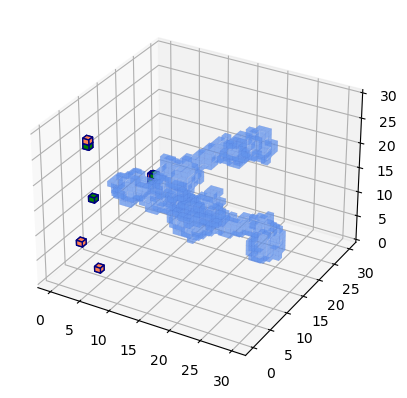

In [22]:
C = np.array([True if idx in voxelgrid.voxel_n else False for idx,c in enumerate(voxelgrid.voxel_centers)]).reshape(n,n,n)
C_ = np.array([True if idx in voxel_n else False for idx,c in enumerate(voxelgrid.voxel_centers)]).reshape(n,n,n)
C__ = np.array([True if idx in ids else False for idx,c in enumerate(voxelgrid.voxel_centers)]).reshape(n,n,n)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.voxels(C, edgecolor='navy',shade=True,facecolor='cornflowerblue',alpha=0.5, linewidth=0.01)
ax.voxels(C_, edgecolor='navy',shade=True,facecolor='coral')
ax.voxels(C__, edgecolor='navy',shade=True,facecolor='green')

In [9]:
import numpy as np
import heapq

def heuristic(a, b):
    """
    Calculate the Manhattan distance between two points.
    """
    return sum(abs(val1-val2) for val1, val2 in zip(a,b))

def a_star_search(voxel_array, start, goal):
    """
    A* pathfinding algorithm to find the shortest path in a voxel array avoiding voxels with value 1.
    """
    neighbors = [(1, 0, 0), (-1, 0, 0), (0, 1, 0), (0, -1, 0), (0, 0, 1), (0, 0, -1)]

    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}
    g_score = {start: 0}
    f_score = {start: heuristic(start, goal)}

    while open_set:
        current = heapq.heappop(open_set)[1]

        if current == goal:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            return path[::-1]

        for dx, dy, dz in neighbors:
            neighbor = (current[0] + dx, current[1] + dy, current[2] + dz)

            # Check if the neighbor is within the bounds of the voxel array and not an obstacle
            if 0 <= neighbor[0] < voxel_array.shape[0] and \
               0 <= neighbor[1] < voxel_array.shape[1] and \
               0 <= neighbor[2] < voxel_array.shape[2] and \
               voxel_array[neighbor] == 0:

                tentative_g_score = g_score[current] + 1
                if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                    heapq.heappush(open_set, (f_score[neighbor], neighbor))

    return None  # Path not found

start = tuple(control_points[0])  # Start index
goal = tuple(control_points[2])   # Goal index
print(start, goal)
print(binary_voxels.shape)
print(binary_voxels[start])

path = a_star_search(binary_voxels, start, goal)
# path


(12, 7, 11) (3, 5, 5)
(15, 15, 15)
0.0


In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_path_in_voxel_space(voxel_array, path, start, goal, control_points=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the obstacles
    obstacles_x, obstacles_y, obstacles_z = np.where(voxel_array == 1)
    ax.scatter(obstacles_x, obstacles_y, obstacles_z, zdir='z', c='red', marker='o', label='Obstacles')

    # Plot the path
    if path:
        path_x, path_y, path_z = zip(*path)
        ax.plot(path_x, path_y, path_z, color='blue', linewidth=2, label='Path')

    # Plot the start and goal points
    ax.scatter(*start, color='green', s=100, label='Start')
    ax.scatter(*goal, color='gold', s=100, label='Goal')

    if control_points is not None:
        control_points_x, control_points_y, control_points_z = zip(*control_points)
        ax.scatter(control_points_x, control_points_y, control_points_z, color='gray', s=100, label='Control Points')

    # Setting labels
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.legend()

    # Show the plot
    plt.show()

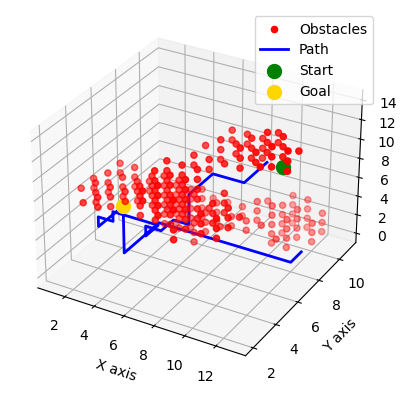

In [11]:
def find_path_through_control_points(voxel_array, points):
    total_path = []
    for i in range(len(points) - 1):
        start = tuple(points[i])
        goal = tuple(points[i + 1])
        segment_path = a_star_search(voxel_array, start, goal)
        if segment_path is None:
            return None  # Path not found for one of the segments
        total_path.extend(segment_path)
    return total_path

# Convert your control points to tuples if they are numpy arrays
control_points = [tuple(point) for point in control_points]

# Now use the function with the converted control points
path_with_control_points = find_path_through_control_points(binary_voxels, control_points)

# Proceed with plotting if a path is found
if path_with_control_points:
    plot_path_in_voxel_space(binary_voxels, path_with_control_points, start, goal)
else:
    print("No path found through the control points.")

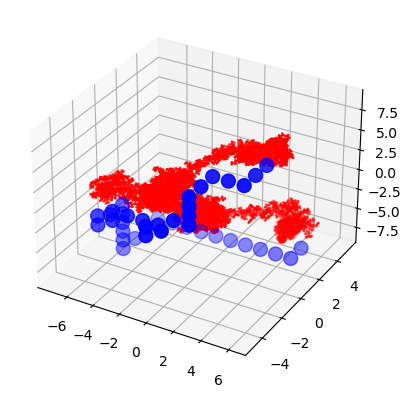

In [12]:
# reshape the voxel array to a 3D array containingt the centers of the voxels

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
path_xyz = np.array([voxelgrid.voxel_centers.reshape(n,n,n,3)[i] for i in path_with_control_points])
path_xyz.shape
ax.scatter(path_xyz[:,0], path_xyz[:,1], path_xyz[:,2], color='blue', s=100, label='Path')
ax.scatter(point_cloud[:,0], point_cloud[:,1], point_cloud[:,2], color='red', s=1, label='Path')

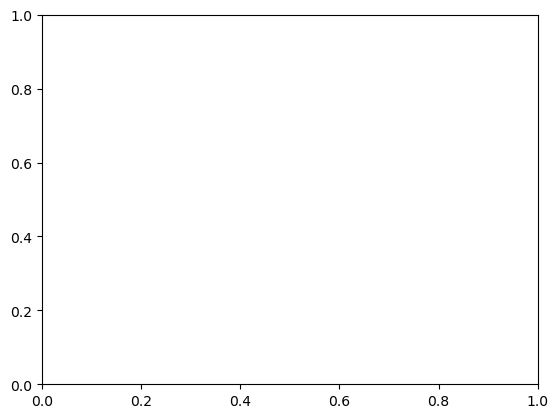

In [13]:
fig, ax = plt.subplots()
labels = ['x','y','z']
x = np.arange(len(labels))  # the label locations
y = n

In [14]:
import numpy as np
from scipy.spatial.distance import cdist

def find_nearest_zero_voxel(voxel_array, voxel_index):
    # Check if the given voxel is 1
    print(voxel_array[voxel_index])
    if voxel_array[voxel_index] != 1:
        return None, "The voxel at the given index does not have a value of 1."

    # Get the coordinates of all voxels with value 0
    zero_voxels = np.argwhere(voxel_array == 0)

    # If there are no zero voxels, return None
    if len(zero_voxels) == 0:
        return None, "There are no voxels with a value of 0."

    # Calculate the distances from the given voxel to all zero voxels
    distances = cdist([voxel_index], zero_voxels)

    # Find the index of the nearest zero voxel
    nearest_zero_voxel_index = zero_voxels[np.argmin(distances)]

    return tuple(nearest_zero_voxel_index), None

# Example usage
n = 10
voxel_array = np.random.randint(0, 2, (n, n, n))
print(voxel_array.shape)
voxel_index = (5, 5, 5)  # Example index

find_nearest_zero_voxel(voxel_array, voxel_index)
voxel_array


(10, 10, 10)
0


array([[[0, 1, 0, 0, 1, 0, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 0, 0, 1, 0, 0],
        [1, 1, 0, 0, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 0, 1, 0, 1, 0, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 0],
        [1, 0, 1, 0, 0, 1, 0, 1, 1, 0],
        [0, 0, 0, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 0, 1, 0, 0, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 1, 0, 0, 1, 1, 1, 0]],

       [[1, 0, 0, 1, 1, 0, 0, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 0, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 0, 0, 0, 0],
        [0, 1, 1, 1, 0, 1, 0, 1, 0, 0],
        [1, 0, 1, 1, 1, 1, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0, 1, 1],
        [0, 1, 0, 0, 1, 1, 1, 0, 1, 0],
        [1, 1, 0, 1, 0, 0, 0, 0, 0, 1]],

       [[1, 0, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
        [0, 1, 0, 1, 1, 0, 1, 0, 1, 0],
        [0, 1, 1, 1, 1, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 1, 1, 0, 1, 0, 

In [15]:
C = np.array([True if idx in voxelgrid.voxel_n else False for idx,c in enumerate(voxelgrid.voxel_centers)]).reshape(n,n,n)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.voxels(C, edgecolor='navy',shade=True,facecolor='cornflowerblue')
# fig.savefig('voxeltest.png',dpi=200)
# plot points
ax.scatter(points[0][0],points[0][1],points[0][1],c='r',s=100)

ValueError: cannot reshape array of size 3375 into shape (10,10,10)

In [16]:



def update_com_position(com, voxelgrid, binary_voxel_array):
    is_inside, voxel_indices = is_inside_voxel(com, voxelgrid, binary_voxel_array)
    if not is_inside:
        return com  # No update needed if it's already outside

    # Find the nearest voxel that is not part of the excluded volume
    neighbors = voxelgrid.get_voxel_neighbors(voxel_indices)
    for neighbor in neighbors:
        if binary_voxel_array[neighbor] == 0:
            # Calculate the physical coordinates of this voxel and return them
            new_com = voxelgrid.get_physical_coordinates(neighbor)
            return new_com

    # If no suitable neighbor is found, return the original CoM
    # In a real scenario, you might want to handle this case differently
    return com



In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_coms_and_voxel_grid(original_coms, adjusted_coms, voxel_grid, voxel_size):
    """
    Plot the original and adjusted CoMs along with the voxel grid.

    Parameters:
    original_coms (array): The original CoMs.
    adjusted_coms (array): The adjusted CoMs.
    voxel_grid (array): The binary voxel grid representation of the protein.
    voxel_size (float): The size of each voxel.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plotting the original CoMs
    ax.scatter(original_coms[:, 0], original_coms[:, 1], original_coms[:, 2], 
               color='red', label='Original CoMs')

    # Plotting the adjusted CoMs
    ax.scatter(adjusted_coms[:, 0], adjusted_coms[:, 1], adjusted_coms[:, 2], 
               color='green', label='Adjusted CoMs')

    # Plotting the voxel grid
    for i in range(voxel_grid.shape[0]):
        for j in range(voxel_grid.shape[1]):
            for k in range(voxel_grid.shape[2]):
                if voxel_grid[i, j, k] == 1:  # If voxel is occupied
                    # Plot each occupied voxel
                    ax.scatter(i * voxel_size, j * voxel_size, k * voxel_size, 
                               color='blue', alpha=0.1)

    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.legend()
    plt.show()

# Flatten the coms array for easier processing
original_coms = coms.reshape(-1, 3)

# Adjust coms using the previously defined functions
adjusted_coms = np.copy(original_coms)
for i in range(adjusted_coms.shape[0]):
    adjusted_coms[i] = update_com_position(adjusted_coms[i], Binary_voxel_array, voxel_size)

# Visualize
plot_coms_and_voxel_grid(original_coms, adjusted_coms, Binary_voxel_array, voxel_size)


AttributeError: 'list' object has no attribute 'reshape'

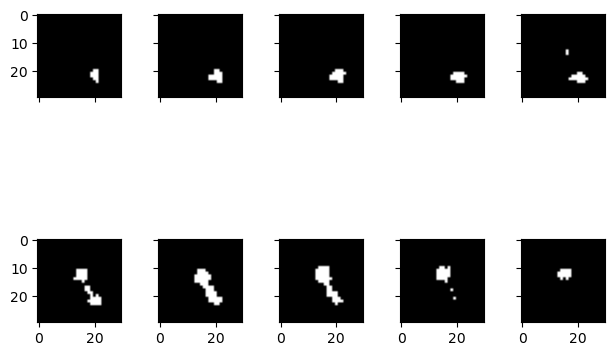

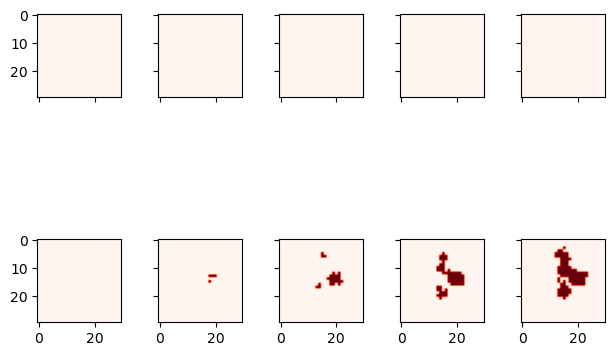

In [18]:
# plot the voxel grid in 2D slices

fig,ax=plt.subplots(n//5,5,sharex=True,sharey=True)
fig.tight_layout()


ax = ax.flatten()
for idx in range(n):
    ax[idx].imshow(Binary_voxel_array[ :, :, idx ], cmap='gray')
    
fig,ax=plt.subplots(n//5,5,sharex=True,sharey=True)
fig.tight_layout()

ax = ax.flatten()
for idx in range(n):
    ax[idx].imshow(Binary_voxel_array[ :, idx, : ], cmap='Reds')

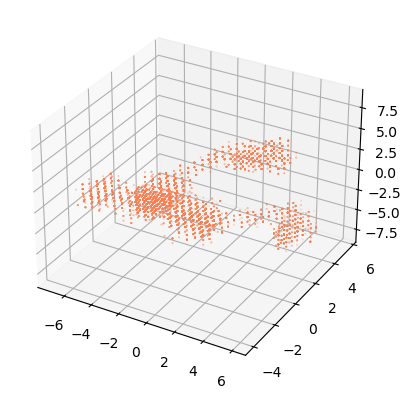

In [19]:
n = 30
voxelgrid_id = cloud.add_structure("voxelgrid",n_x=n, n_y=n, n_z=n)
voxelgrid = cloud.structures[voxelgrid_id]

C = voxelgrid.voxel_centers[voxelgrid.voxel_n]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(C[:,0],C[:,1],C[:,2],c='coral',s=0.1)

{(3, 9, 15): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x186010390>,
 (3, 10, 13): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x187e33c50>,
 (3, 10, 15): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x186402890>,
 (3, 11, 13): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x186403bd0>,
 (3, 11, 15): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x1863f3610>,
 (4, 9, 13): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x1863f0c10>,
 (4, 9, 14): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x1863f2b50>,
 (4, 10, 13): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x18614b0d0>,
 (4, 10, 16): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x18640e410>,
 (4, 11, 13): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x18640f590>,
 (4, 11, 15): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x18640c990>,
 (4, 12, 14): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x186512a90>,
 (4, 12, 15): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x186513d90>,
 (5, 7, 15): <m

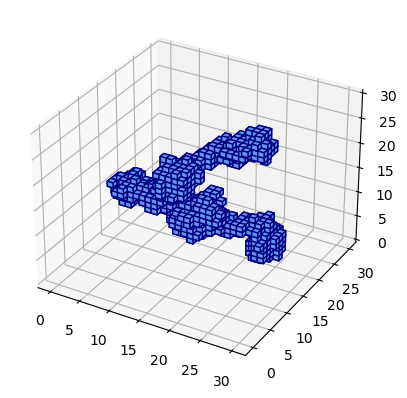

In [20]:
C = np.array([True if idx in voxelgrid.voxel_n else False for idx,c in enumerate(voxelgrid.voxel_centers)]).reshape(n,n,n)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.voxels(C, edgecolor='navy',shade=True,facecolor='cornflowerblue')
# fig.savefig('voxeltest.png',dpi=200)

In [21]:
C[np.where(C==True)] = 0
C[np.where(C==False)] = 1
C

array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  Tr